<a href="https://colab.research.google.com/github/elroedan/HackUSU-Hackathon/blob/main/bike_project/starter_bikes_fixed_scaling_dummies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Dictionary
 - instant: record index
 - dteday : date
 - season : season (1:winter, 2:spring, 3:summer, 4:fall)
 - hr : hour (0 to 23)
 - holiday : weather day is holiday or not
 - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog - temp_c : temperature in Celsius. - feels_like_c: "Feels like" temperature in Celsius. - hum: humidity percentage- windspeed: Wind speed.- casual: count of casual users - registered: count of registered users

Preparing the data

spacer

In [ ]:
# spacer


I was previously using keras.Sequential but that did not work best with time series data. "This model is suitable when your neural network is a straightforward stack of layers" this was obtain from notebookLM.

Ai mentioned LSTM, GRU and CNN work best for time series data but havent confirmed with notes.

So after looking at notes I ran into RNNs and LSTMs but my model got worse.

Since we are not predicting future values but predicting data around same time frame then we need to get rid of the time series aspect and assgin categories. Like have categories that depict colder than usual year. have one that highlights causal and registered decline etc.

notes:
(RNNs) are particularly useful in analyzing data or processes that change over time,

Test MSE: 1459.46, Test MAE: 20.83, Test R²: 0.9119 cont + range month

Test MSE: 1602.22, Test MAE: 21.54  continue + 154 month category continue

Test MSE: 5557.45, Test MAE: 42.44 w/ logs & no zero weather continue

Test MSE: 5392.82, Test MAE: 43.13 w/ logs continue

Test MSE: 5501.99, Test MAE: 43.47 w/out logs discontinue

I'doing a RNN and LSTMs model to better fit the time series data

I'm doing model 3, which is the same as model 2 or testing and predicting two targets. In this one I'm using different columns for each target. I also added a category for the month. so lowest months have the same category, mid months same category etc.

My main goal so far with my modified columns is to de time series this data, since we are not predicting future values (after 10/2023)

One problem we can run into. Is this code is categorizing months base on overall average. So when doing the test sample, the extra columns need to be added to the test holdoud preditions to turn in. When adding the extra columns like casual_m_cat. I need to assign those values base on the month that the holdout test data was giving and not do the calculations for casual_m_cat since this data set is smaller and outliers can throw the results slightly off.

In [16]:
# --------------------------
# model 3
# DOing two features instead of 1
# code 1 out 2
# --------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score




# 1) Load data
bikes = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv")
bikes['dteday'] = pd.to_datetime(bikes['dteday'], format='%m/%d/%Y')

# 2) Basic transformations
bikes['month'] = bikes['dteday'].dt.month

# DAVID CHANGES
bikes['day_of_week'] = bikes['dteday'].dt.day_of_week
bikes['year'] = bikes['dteday'].dt.year #ignored for now
bikes['time_of_day'] = pd.cut(bikes['hr'], bins=[0, 6, 12, 18, 24], labels=['1', '2', '3', '4'])
# bikes = pd.get_dummies(bikes, columns=['time_of_day'], drop_first=False, sparse=False)
###############

bikes['hum'] = np.log1p(bikes['hum'])
bikes['windspeed'] = np.log1p(bikes['windspeed'])
bikes['feels_like_c'] = np.log1p(bikes['feels_like_c'] + 25)
bikes['temp_c'] = np.log1p(bikes['temp_c'] + 25)
bikes['month_c'] = (bikes['dteday'].dt.year - 2011)*12 + bikes['dteday'].dt.month

bikes['casual_m'] = bikes.groupby(
    [bikes['dteday'].dt.year, bikes['dteday'].dt.month]
)['casual'].transform('mean')
bikes['registered_m'] = bikes.groupby(
    [bikes['dteday'].dt.year, bikes['dteday'].dt.month]
)['registered'].transform('mean')

# Define percentiles for qcut
quantiles = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
             0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90,
             0.95, 1.0]

bikes['casual_m_cat'] = pd.qcut(bikes['casual_m'], q=quantiles, labels=range(1, 21)).astype('category')
bikes['registered_m_cat'] = pd.qcut(bikes['registered_m'], q=quantiles, labels=range(1, 21)).astype('category')

cat_cols = ['season', 'hr', 'holiday', 'workingday', 'weathersit',
            'month', 'month_c', 'casual_m_cat', 'registered_m_cat', 'time_of_day']
bikes[cat_cols] = bikes[cat_cols].astype('category')

# 3) Subset each target's columns *before* one-hot encoding.
### DAVID ADDED HOUR BIN, DAY OF WEEK
sub_casual = bikes[['hr', 'temp_c', 'feels_like_c', 'hum', 'windspeed',
                    'season', 'holiday', 'workingday', 'weathersit',
                    'month', 'time_of_day', 'day_of_week', 'casual_m_cat']] # remove month_c

sub_registered = bikes[['hr', 'temp_c', 'feels_like_c', 'hum', 'windspeed',
                        'season', 'holiday', 'workingday', 'weathersit',
                        'month', 'time_of_day', 'day_of_week', 'registered_m_cat']] # remove month_c
########################




# I think this is causing the main error. dummies is the one making coulmns for variables
X_casual = pd.get_dummies(sub_casual, drop_first=False)
#X_casual = sub_casual

pd.set_option('display.max_columns', None)  # Set option to show all columns

#print("First 500 rows of X_casual with all columns:") --------------------see list
#print(X_casual.head(500)) ------------------ see list

X_registered = pd.get_dummies(sub_registered, drop_first=False)
#X_registered = sub_registered

# 5) Define targets from the original or same DataFrame
y_casual = bikes['casual']
y_registered = bikes['registered']

# 6) Train/test split & scale
X_train_casual, X_test_casual, y_train_casual, y_test_casual = train_test_split(
    X_casual, y_casual, test_size=0.2, random_state=42
)
X_train_registered, X_test_registered, y_train_registered, y_test_registered = train_test_split(
    X_registered, y_registered, test_size=0.2, random_state=42
)

#scaler_casual = StandardScaler()
#X_train_casual_scaled = scaler_casual.fit_transform(X_train_casual)
#X_test_casual_scaled = scaler_casual.transform(X_test_casual)

#scaler_registered = StandardScaler()
#X_train_registered_scaled = scaler_registered.fit_transform(X_train_registered)
#X_test_registered_scaled = scaler_registered.transform(X_test_registered)

print("\n=== Before Scaling - X_train_casual (First 5 rows) ===")
print(X_train_casual.head())
print("\n=== Before Scaling - X_test_casual (First 5 rows) ===")
print(X_test_casual.head())


scaler_casual = StandardScaler()
#scaler_casual = MinMaxScaler()
X_train_casual_scaled = scaler_casual.fit_transform(X_train_casual)
X_test_casual_scaled = scaler_casual.transform(X_test_casual)

print("\n=== After Scaling - X_train_casual_scaled (First 5 rows) ===")
print(X_train_casual_scaled[:5]) # Print first 5 rows of the numpy array
print("\n=== After Scaling - X_test_casual_scaled (First 5 rows) ===")
print(X_test_casual_scaled[:5]) # Print first 5 rows of the numpy array



# print("\n=== Before Scaling - X_train_registered (First 5 rows) ===")
# print(X_train_registered.head())
# print("\n=== Before Scaling - X_test_registered (First 5 rows) ===")
# print(X_test_registered.head())


scaler_registered = StandardScaler()
#scaler_registered = MinMaxScaler()
X_train_registered_scaled = scaler_registered.fit_transform(X_train_registered)
X_test_registered_scaled = scaler_registered.transform(X_test_registered)

# print("\n=== After Scaling - X_train_registered_scaled (First 5 rows) ===")
# print(X_train_registered_scaled[:5]) # Print first 5 rows of the numpy array
# print("\n=== After Scaling - X_test_registered_scaled (First 5 rows) ===")
# print(X_test_registered_scaled[:5]) # Print first 5 rows of the numpy array



=== Before Scaling - X_train_casual (First 5 rows) ===
         temp_c  feels_like_c       hum  windspeed  day_of_week  hr_0.0  \
22023  4.075841      4.130355  0.409723   3.044522            5   False   
30281  3.899950      3.899950  0.533448   2.261763            6   False   
83263  4.014580      4.053523  0.466999   2.760010            2   False   
63147  3.377588      3.148453  0.270943   3.648057            4   False   
18592  3.404525      3.258097  0.615942   3.010621            2   False   

       hr_1.0  hr_2.0  hr_3.0  hr_4.0  hr_5.0  hr_6.0  hr_7.0  hr_8.0  hr_9.0  \
22023   False   False   False   False   False   False   False   False   False   
30281   False   False   False   False   False   False   False   False   False   
83263   False   False   False   False   False   False   False   False   False   
63147   False   False   False   False   False   False   False   False   False   
18592   False   False   False   False   False   False   False   False   False   

      

spacer

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Model for Casual ===
Epoch 1/3
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7761.3589 - mae: 46.0238 - val_loss: 2029.4734 - val_mae: 25.4702
Epoch 2/3
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1906.5780 - mae: 23.8691 - val_loss: 1740.1866 - val_mae: 22.8717
Epoch 3/3
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 1614.9954 - mae: 22.0894 - val_loss: 1826.8585 - val_mae: 23.5110

=== Model for Registered ===
Epoch 1/3
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 43540.5547 - mae: 123.7912 - val_loss: 6802.9683 - val_mae: 52.5105
Epoch 2/3
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6406.1040 - mae: 50.0473 - val_loss: 5595.3252 - val_mae: 45.9455
Epoch 3/3
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5454.1436 - mae: 45.2236 - val_loss: 5178.8906 - val_mae: 43.8240

=== EVALUATION: CASUAL MODEL ===
Casual - Test MSE: 1701.52, Test MAE: 23.03
703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Casual - R²: 0.8973

=== EVALUATION: REGISTERED MODEL ===
Re

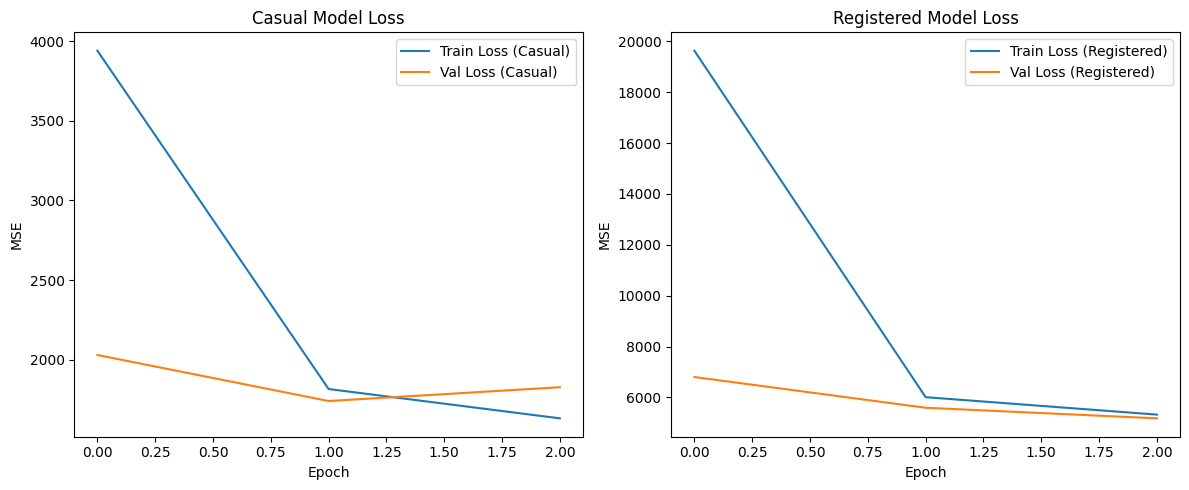

In [2]:
# --------------------------
# model 3
# DOing two features instead of 1
# code 2 out 2
# --------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
from keras import layers # use this instead of layers


# 7) Build & compile model function
def build_model(input_dim):
    model = keras.Sequential([
        keras.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 8) Train 2 separate models
model_casual = build_model(X_train_casual_scaled.shape[1])
print("\n=== Model for Casual ===")
history_casual = model_casual.fit(
    X_train_casual_scaled, y_train_casual,
    epochs=3, batch_size=64, validation_split=0.2, verbose=1
)

model_registered = build_model(X_train_registered_scaled.shape[1])
print("\n=== Model for Registered ===")
history_registered = model_registered.fit(
    X_train_registered_scaled, y_train_registered,
    epochs=3, batch_size=64, validation_split=0.2, verbose=1
)

# 9) Evaluate
print("\n=== EVALUATION: CASUAL MODEL ===")
test_loss_casual, test_mae_casual = model_casual.evaluate(X_test_casual_scaled, y_test_casual, verbose=0)
print(f"Casual - Test MSE: {test_loss_casual:.2f}, Test MAE: {test_mae_casual:.2f}")
y_pred_casual = model_casual.predict(X_test_casual_scaled)
r2_casual = r2_score(y_test_casual, y_pred_casual)
print(f"Casual - R²: {r2_casual:.4f}")

print("\n=== EVALUATION: REGISTERED MODEL ===")
test_loss_registered, test_mae_registered = model_registered.evaluate(X_test_registered_scaled, y_test_registered, verbose=0)
print(f"Registered - Test MSE: {test_loss_registered:.2f}, Test MAE: {test_mae_registered:.2f}")
y_pred_registered = model_registered.predict(X_test_registered_scaled)
r2_registered = r2_score(y_test_registered, y_pred_registered)
print(f"Registered - R²: {r2_registered:.4f}")

# 10) Plot losses
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Casual
plt.subplot(1,2,1)
plt.plot(history_casual.history['loss'], label='Train Loss (Casual)')
plt.plot(history_casual.history['val_loss'], label='Val Loss (Casual)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Casual Model Loss')
plt.legend()

# Registered
plt.subplot(1,2,2)
plt.plot(history_registered.history['loss'], label='Train Loss (Registered)')
plt.plot(history_registered.history['val_loss'], label='Val Loss (Registered)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Registered Model Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
bikes_holdout = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini.csv")
expected = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini_answers.csv")

bikes_holdout['dteday'] = pd.to_datetime(bikes_holdout['dteday'], format='%m/%d/%Y')

# 2) Basic transformations
bikes_holdout['month'] = bikes_holdout['dteday'].dt.month

# DAVID CHANGES
bikes_holdout['day_of_week'] = bikes_holdout['dteday'].dt.day_of_week
bikes_holdout['year'] = bikes_holdout['dteday'].dt.year #ignored for now
bikes_holdout['time_of_day'] = pd.cut(bikes_holdout['hr'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'])
# bikes_holdout = pd.get_dummies(bikes_holdout, columns=['time_of_day'], drop_first=False, sparse=False)
###############

bikes_holdout['hum'] = np.log1p(bikes_holdout['hum'])
bikes_holdout['windspeed'] = np.log1p(bikes_holdout['windspeed'])
bikes_holdout['feels_like_c'] = np.log1p(bikes_holdout['feels_like_c'] + 25)
bikes_holdout['temp_c'] = np.log1p(bikes_holdout['temp_c'] + 25)
bikes_holdout['month_c'] = (bikes_holdout['dteday'].dt.year - 2011)*12 + bikes_holdout['dteday'].dt.month

# For the mini set, you may need to handle or assign casual_m_cat, registered_m_cat:
bikes_holdout['casual_m_cat'] = None
bikes_holdout['registered_m_cat'] = None

# (Your logic for assigning categories, if applicable)
# Example:
bikes_holdout.loc[(bikes_holdout['dteday'].dt.year == 2023) & (bikes_holdout['dteday'].dt.month == 11), 'casual_m_cat'] = 10
bikes_holdout.loc[(bikes_holdout['dteday'].dt.year == 2023) & (bikes_holdout['dteday'].dt.month == 11), 'registered_m_cat'] = 11
bikes_holdout.loc[(bikes_holdout['dteday'].dt.year == 2023) & (bikes_holdout['dteday'].dt.month == 12), 'casual_m_cat'] = 5
bikes_holdout.loc[(bikes_holdout['dteday'].dt.year == 2023) & (bikes_holdout['dteday'].dt.month == 12), 'registered_m_cat'] = 6


cat_cols = ['season', 'hr', 'holiday', 'workingday', 'weathersit',
            'month', 'month_c', 'casual_m_cat', 'registered_m_cat', 'time_of_day']
bikes_holdout[cat_cols] = bikes_holdout[cat_cols].astype('category')

# 3) Subset each target's columns *before* one-hot encoding.
### DAVID ADDED HOUR BIN, DAY OF WEEK
sub_casual_test = bikes_holdout[['hr', 'temp_c', 'feels_like_c', 'hum', 'windspeed',
                    'season', 'holiday', 'workingday', 'weathersit',
                    'month', 'time_of_day', 'day_of_week', 'casual_m_cat']] # remove month_c

sub_registered_test = bikes_holdout[['hr', 'temp_c', 'feels_like_c', 'hum', 'windspeed',
                        'season', 'holiday', 'workingday', 'weathersit',
                        'month', 'time_of_day', 'day_of_week', 'registered_m_cat']] # remove month_c
########################

# 4) Now we do one-hot encoding separately for each subset

X_casual_test = pd.get_dummies(sub_casual_test, drop_first=True).reindex(columns=X_casual.columns, fill_value=0)
#X_casual_test = pd.get_dummies(sub_casual_test, drop_first=True) # added test to sub causal and reg
X_registered_test = pd.get_dummies(sub_registered_test, drop_first=True).reindex(columns=X_registered.columns, fill_value=0)

print("\n=== Before Scaling - X_casual_test (First 5 rows) ===")
print(X_casual_test.head())
print("\n=== Before Scaling - X_registered_test (First 5 rows) ===")
print(X_registered_test.head())

X_test_casual_test_scaled = scaler_casual.transform(X_casual_test) # Use the *already fitted* scaler
X_test_registered_test_scaled = scaler_registered.transform(X_registered_test) # Use the *already fitted* scaler

print("\n=== After Scaling - X_test_casual_test_scaled (First 5 rows) ===")
print(X_test_casual_test_scaled[:5]) # Print first 5 rows of the numpy array
print("\n=== After Scaling - X_test_registered_test_scaled (First 5 rows) ===")
print(X_test_registered_test_scaled[:5]) # Print first 5 rows of the numpy arra



pred_casual = model_casual.predict(X_casual_test)
r2_casual = r2_score(expected["casual"], pred_casual)
print(f"Casual - R²: {r2_casual:.4f}")

pred_registered = model_registered.predict(X_registered_test)
r2_registered = r2_score(expected["registered"], pred_registered)
print(f"Registered - R²: {r2_registered:.4f}")



predictions_df = pd.DataFrame({
    'casual': pred_casual.flatten(),  # flatten() to convert to 1D array if needed
    'registered': pred_registered.flatten() # flatten() to convert to 1D array if needed
})




=== Before Scaling - X_casual_test (First 5 rows) ===
     temp_c  feels_like_c       hum  windspeed  day_of_week  hr_0.0  hr_1.0  \
0  3.505557      3.505557  0.510846   0.000000            2       0   False   
1  3.471966      3.471966  0.554230   0.000000            2       0    True   
2  3.440418      3.374169  0.600593   2.251292            2       0   False   
3  3.456317      3.387774  0.563779   2.341806            2       0   False   
4  3.440418      3.363842  0.583221   2.406945            2       0   False   

   hr_2.0  hr_3.0  hr_4.0  hr_5.0  hr_6.0  hr_7.0  hr_8.0  hr_9.0  hr_10.0  \
0   False   False   False   False   False   False   False   False    False   
1   False   False   False   False   False   False   False   False    False   
2    True   False   False   False   False   False   False   False    False   
3   False    True   False   False   False   False   False   False    False   
4   False   False    True   False   False   False   False   False    False   

 

In [4]:
# this can go at the end of code 3 of 3

# 3. Save DataFrame to a CSV file
#csv_filename = 'biking_predictions.csv'  # You can choose your filename
#predictions_df.to_csv(csv_filename, index=False) # index=False to avoid saving DataFrame index as a column
#print(f"Predictions saved to '{csv_filename}'")


#print("\n--- SHAPES AND COLUMN NAMES - BEFORE SCALING ---")

print("\n=== X_casual_test ===")
print("Shape:", X_casual_test.shape)
print("Columns:", X_casual_test.columns.tolist())  # Use .tolist() for cleaner output

print("\n=== X_casual ===")
print("Shape:", X_casual.shape)
print("Columns:", X_casual.columns.tolist())

print("\n=== X_registered_test ===")
print("Shape:", X_registered_test.shape)
print("Columns:", X_registered_test.columns.tolist())

print("\n=== X_registered ===")
print("Shape:", X_registered.shape)
print("Columns:", X_registered.columns.tolist())

print("\n--- SHAPES AND COLUMN NAMES - AFTER SCALING ---")

print("\n=== X_test_casual_test_scaled ===")
print("Shape:", X_test_casual_test_scaled.shape)
# Columns are lost after scaling with MinMaxScaler on the scaled arrays directly
# If you want to keep column names after scaling, you'd need to apply scaling column-wise to DataFrames
# or reconstruct a DataFrame from the scaled numpy array and original column names.

print("\n=== X_train_casual_scaled ===")
print("Shape:", X_train_casual_scaled.shape)
# Columns are lost after scaling with MinMaxScaler on the scaled arrays directly

print("\n=== X_test_registered_test_scaled ===")
print("Shape:", X_test_registered_test_scaled.shape)
# Columns are lost after scaling with MinMaxScaler on the scaled arrays directly

print("\n=== X_train_registered_scaled ===")
print("Shape:", X_train_registered_scaled.shape)
# Columns are lost after scaling with MinMaxScaler on the scaled arrays directly


=== X_casual_test ===
Shape: (384, 77)
Columns: ['temp_c', 'feels_like_c', 'hum', 'windspeed', 'day_of_week', 'hr_0.0', 'hr_1.0', 'hr_2.0', 'hr_3.0', 'hr_4.0', 'hr_5.0', 'hr_6.0', 'hr_7.0', 'hr_8.0', 'hr_9.0', 'hr_10.0', 'hr_11.0', 'hr_12.0', 'hr_13.0', 'hr_14.0', 'hr_15.0', 'hr_16.0', 'hr_17.0', 'hr_18.0', 'hr_19.0', 'hr_20.0', 'hr_21.0', 'hr_22.0', 'hr_23.0', 'season_1', 'season_2', 'season_3', 'season_4', 'holiday_0', 'holiday_1', 'workingday_0', 'workingday_1', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'time_of_day_1', 'time_of_day_2', 'time_of_day_3', 'time_of_day_4', 'casual_m_cat_1', 'casual_m_cat_2', 'casual_m_cat_3', 'casual_m_cat_4', 'casual_m_cat_5', 'casual_m_cat_6', 'casual_m_cat_7', 'casual_m_cat_8', 'casual_m_cat_9', 'casual_m_cat_10', 'casual_m_cat_11', 'casual_m_cat_12', 'casual_m_cat_13', 'casual_m_cat_14', 'casu

spacer

In [22]:
bikes_holdout['casual_m_cat']

,casual_m_cat
0,10
1,10
2,10
3,10
4,10
...,...
379,10
380,10
381,10
382,10


<ipython-input-23-284c8847cc7b>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='season', y='total_rentals', data=bikes_holdout, ax=axes[1, 0], palette='viridis', estimator=sum)


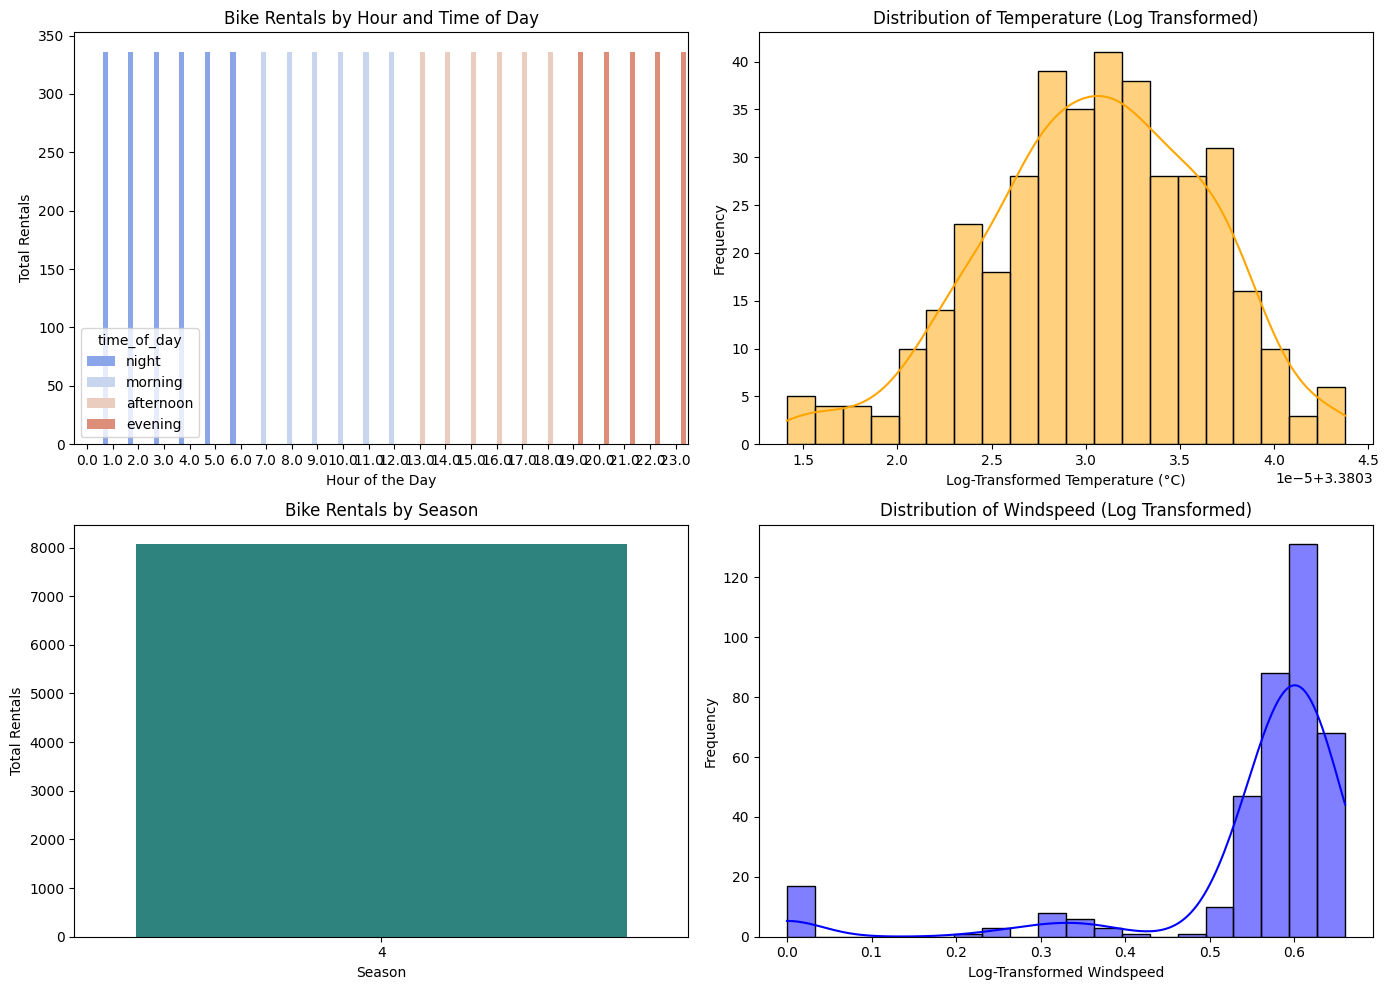

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert date column to datetime format
bikes_holdout['dteday'] = pd.to_datetime(bikes_holdout['dteday'], format='%m/%d/%Y')

# Extract time-based features
bikes_holdout['month'] = bikes_holdout['dteday'].dt.month
bikes_holdout['day_of_week'] = bikes_holdout['dteday'].dt.day_of_week
bikes_holdout['year'] = bikes_holdout['dteday'].dt.year
bikes_holdout['time_of_day'] = pd.cut(bikes_holdout['hr'], bins=[0, 6, 12, 18, 24],
                                      labels=['night', 'morning', 'afternoon', 'evening'])

# Apply log transformation to weather-related variables
bikes_holdout['hum'] = np.log1p(bikes_holdout['hum'])
bikes_holdout['windspeed'] = np.log1p(bikes_holdout['windspeed'])
bikes_holdout['feels_like_c'] = np.log1p(bikes_holdout['feels_like_c'] + 25)
bikes_holdout['temp_c'] = np.log1p(bikes_holdout['temp_c'] + 25)

# Define categories for visualization
bikes_holdout['season'] = bikes_holdout['season'].astype('category')
bikes_holdout['hr'] = bikes_holdout['hr'].astype('category')
bikes_holdout['holiday'] = bikes_holdout['holiday'].astype('category')
bikes_holdout['workingday'] = bikes_holdout['workingday'].astype('category')
bikes_holdout['weathersit'] = bikes_holdout['weathersit'].astype('category')
bikes_holdout['month'] = bikes_holdout['month'].astype('category')
bikes_holdout['time_of_day'] = bikes_holdout['time_of_day'].astype('category')

# Calculate total rentals
# Make sure both 'casual_m_cat' and 'registered_m_cat' are numeric
bikes_holdout['casual_m_cat'] = pd.to_numeric(bikes_holdout['casual_m_cat'], errors='coerce')
bikes_holdout['registered_m_cat'] = pd.to_numeric(bikes_holdout['registered_m_cat'], errors='coerce')

# Then calculate total rentals
bikes_holdout['total_rentals'] = bikes_holdout['casual_m_cat'] + bikes_holdout['registered_m_cat']

bikes_holdout['total_rentals'] = bikes_holdout['casual_m_cat'] + bikes_holdout['registered_m_cat']

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Chart 1: Corrected Bike rentals by hour and time of day
sns.barplot(x='hr', y='total_rentals', hue='time_of_day', data=bikes_holdout, ax=axes[0, 0], palette='coolwarm', estimator=sum)
axes[0, 0].set_title("Bike Rentals by Hour and Time of Day")
axes[0, 0].set_xlabel("Hour of the Day")
axes[0, 0].set_ylabel("Total Rentals")

# Chart 2: Temperature impact on rentals
sns.histplot(bikes_holdout['temp_c'], bins=20, kde=True, ax=axes[0, 1], color='orange')
axes[0, 1].set_title("Distribution of Temperature (Log Transformed)")
axes[0, 1].set_xlabel("Log-Transformed Temperature (°C)")
axes[0, 1].set_ylabel("Frequency")

# Chart 3: Corrected Rentals by season
sns.barplot(x='season', y='total_rentals', data=bikes_holdout, ax=axes[1, 0], palette='viridis', estimator=sum)
axes[1, 0].set_title("Bike Rentals by Season")
axes[1, 0].set_xlabel("Season")
axes[1, 0].set_ylabel("Total Rentals")

# Chart 4: Effect of windspeed on rentals
sns.histplot(bikes_holdout['windspeed'], bins=20, kde=True, ax=axes[1, 1], color='blue')
axes[1, 1].set_title("Distribution of Windspeed (Log Transformed)")
axes[1, 1].set_xlabel("Log-Transformed Windspeed")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()
